# 3.1 テキスト分類のファインチューニング

本 Notebook では、MARC-ja という Amazon のレビューデータセットを用いて、ポジネガ判定用にモデルをファインチューニングします。

モデルの評価は、「1-2_text_classification_eval.ipynb」 をご確認ください。

## 事前準備

ファインチューニングの準備として、ライブラリのインストールやデータセットの準備などを行います。

### (1) ライブラリのインストール

利用するライブラリをインストールします。

In [ ]:
# ライブラリのインストール
!pip install scikit-learn==1.2.2 transformers==4.38.2 datasets==2.18.0 accelerate==0.28.0 evaluate==0.4.1 japanize_matplotlib==1.1.3 fugashi==1.3.0 unidic_lite==1.0.8 pyarrow==14.0.2 fsspec==2023.6.0 gcsfs==2023.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 利用するライブラリのインポート
import os
import random
import sys

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from transformers.trainer_utils import set_seed

In [ ]:
# 不要なwarningメッセージを除外
import warnings
warnings.simplefilter("ignore")

定数の定義を行います。




In [ ]:
# 定数の宣言
MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"  # 利用するモデル名
TRAIN_LOG_OUTPUT = "./logs"  # 学習ログの保存先
MAX_LENGTH = 512  # 入力の最大トークン
SEED_VALUE = 42  # 乱数SEED値の固定

# 乱数シード値をseed_valueに固定
def set_seed_function(seed_value: int = 0) -> None:
    """
    Set the seed value for reproducibility.

    Args:
        seed_value (int, optional): The seed value to set. Defaults to 0.
    """
    set_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# 乱数シード値の固定
set_seed_function(SEED_VALUE)

# 利用するデバイスの確認（GPU or CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


以下のコードにて、モデルの保存先を指定します。

本 Notebook を Google Colab で実行する場合は、Google ドライブの `fine-turning_cookbook/chapter3/models/text_classification` フォルダにモデルを保存します。そうでない場合は、`./models/text_classification` ディレクトリにモデルを保存するようにしています。

保存先を変更する場合は、変数 `MODEL_OUTPUT` の値を変更してください。

Google ドライブに保存する場合、「このノートブックに Google ドライブへのファイルへのアクセスを許可しますか？」という内容のポップアップが出現しますので、許可してください。



In [ ]:
# Google Colab で実行している場合、Google ドライブにモデルを保存するための準備をする
if "google.colab" in sys.modules:
    # Googleドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')
    # モデルの保存先
    MODEL_OUTPUT = "drive/MyDrive/fine-turning_cookbook/chapter3/models/text_classification"
else:
    # モデルの保存先
    MODEL_OUTPUT = "./models/text_classification"

# 保存先のフォルダが存在しない場合はフォルダを作成する
os.makedirs(MODEL_OUTPUT, exist_ok=True)

Mounted at /content/drive


### (2) データセットの準備

今回は、 Hugging Face で公開されているデータセットを利用します。

* URL: https://huggingface.co/datasets/shunk031/JGLUE

In [ ]:
# データセットの読み込み
train_dataset = load_dataset(
    "shunk031/JGLUE",
    name="MARC-ja",
    split="train"
)
valid_dataset = load_dataset(
    "shunk031/JGLUE",
    name="MARC-ja",
    split="validation"
)

# データセットの概要を表示する
print("訓練データ")
print(train_dataset)
print("評価データ")
print(valid_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

訓練データ
Dataset({
    features: ['sentence', 'label', 'review_id'],
    num_rows: 187528
})
評価データ
Dataset({
    features: ['sentence', 'label', 'review_id'],
    num_rows: 5654
})


In [ ]:
# データセットの中身を確認する
print("trainデータ")
print(train_dataset[0])
print(train_dataset[10])

print("validationデータ")
print(valid_dataset[0])
print(valid_dataset[10])

trainデータ
{'sentence': '以前職場の方にこれをみて少しでも元氣になってくださいと手渡して、早３年。返してくれと一度言ったが、結局返ってこなかった。６年前にも、職場の（といっても海外ですが）英語の先生に貸したら、これは素晴らしい！と言って、授業でも何度も生徒に見せたり、家でも見てたりしたそうで、結局帰国までに返してもらえなかった。。。この作品、結局３回購入してます。とほほでありつつ、誰かの心の支えになってくれればと願いつつ。エンディングの曲も好きです。あー、自分も突き進む人生を歩みたい。結婚もしたいが。。。', 'label': 0, 'review_id': 'R2H83XHJUDZBHT'}
{'sentence': '実際にあった話ってこんなに感動的なの！？と思わせられるほど、ゲームの展開が劇的でした。演出的には魅せる部分はあるでしょうが、事実に基づいている話だけに、その演出がさらに感動を引き立てていますね。全体的に派手さはありませんが、見入ってしまう自分がいました。', 'label': 0, 'review_id': 'RS1F2NRIOEC4X'}
validationデータ
{'sentence': '購入するほどのものではなかったように思います。レンタルで見ましたが、「聖なる予言」の復習は出来ました。本がよく売れていたのは、10年前ほど前だったでしょうか。その後、オウム真理教の事件などで急に売れなくなった本でもありました。「ヤングスーパーマン」の主人公にとてもよく似た俳優が主人公だったので、私にとっては運命的で必然のＤＶＤであったと感じています。「聖なる予言」の本の内容の復習には最適でした。', 'label': 0, 'review_id': 'R2MV62E8RAJ4X8'}
{'sentence': 'ひとつのストーリーの中に、3つのゲームがあります。こどもに遊ばせるには、ちょうどいいです。', 'label': 0, 'review_id': 'RFIITGH4EOWSC'}


In [ ]:
# labelの中身を確認する
print(train_dataset.features["label"])

ClassLabel(names=['positive', 'negative', 'neutral'], id=None)


### (3) モデルの読み込み

テキスト分類に利用するモデルを準備します。

変数 `MODEL_NAME` で指定したモデルを読み込みます。

In [ ]:
# ラベルの情報を保存
classes = train_dataset.features["label"]  # ラベルの情報を取得
id2label = {}  # IDからラベルを取得するための辞書
label2id = {}  # ラベルからIDを取得するための辞書
for i in range(train_dataset.features["label"].num_classes):
    id2label[i] = train_dataset.features["label"].int2str(i)
    label2id[train_dataset.features["label"].int2str(i)] = i

# モデルの読み込みとラベル情報の付与
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,  # 事前学習済みモデル名
    num_labels=classes.num_classes,  # ラベル数
    label2id=label2id,  # ラベルからIDを取得するための辞書
    id2label=id2label,  # IDからラベルを取得するための辞書
)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (4) トークナイザの準備

テキストをトークン単位で扱えるようにするために、トークナイザを準備します。

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

テキストがどのように分割されるか確認します。

In [ ]:
text = "こどもに遊ばせるには、ちょうどいいです。"

# トークナイザを利用して、テキストをトークン化し、どのように分割されるかを確認する
print(tokenizer.tokenize(text))

# トークナイザを利用して、テキストをエンコード（トークンIDに変換）し、内部でどのように扱われるのかを確認する
print(tokenizer(text))

['こども', 'に', '遊', '##ば', 'せる', 'に', 'は', '、', 'ちょうど', 'いい', 'です', '。']
{'input_ids': [2, 21533, 461, 6039, 7252, 12729, 461, 465, 384, 22468, 13700, 13037, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
def tokenize_dataset(example) -> dict:
    """
    入力データをトークンIDに変換する

    Args:
        example (dict): 入力文とラベルを含む辞書(トークナイズ化対象のデータセット)

    Returns:
        dict: トークンIDに変換された入力文とラベルを含む辞書
    """

    example_output = tokenizer(example["sentence"], truncation=True)
    example_output["label"] = example["label"]
    return example_output


# トークン化の実行
tokenized_train_datasets = train_dataset.map(tokenize_dataset, batched=True)
tokenized_valid_datasets = valid_dataset.map(tokenize_dataset, batched=True)

Parameter 'function'=<function tokenize_dataset at 0x7f87c193a680> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/187528 [00:00<?, ? examples/s]

Map:   0%|          | 0/5654 [00:00<?, ? examples/s]

バッチごとに padding する Dynamic Padding にて padding を行い、長さを揃えるための準備を行います。

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### (5) データの確認

トークナイザを用意したことで、データセットを分析することができるようになりました。
どのようなデータを扱うのか実際に見てみましょう。

In [ ]:
def show_label_count(dataset: dict) -> None:
    """
    データセットに含まれるレベルの数をカウントする

    Args:
        dataset (dict): データセット

    Returns:
        None
    """
    dataset.set_format(type="pandas")
    df = dataset[:]
    print(df.value_counts(["label"]))
    dataset.reset_format()


print("訓練データ")
show_label_count(train_dataset)
print("検証データ")
show_label_count(valid_dataset)

訓練データ
label
0        165477
1         22051
Name: count, dtype: int64
検証データ
label
0        4832
1         822
Name: count, dtype: int64


trainデータの平均トークン数: 116.08
trainデータの最大トークン数: 424
trainデータのポジティブ平均トークン数: 117.16
trainデータのネガティブ平均トークン数: 107.99


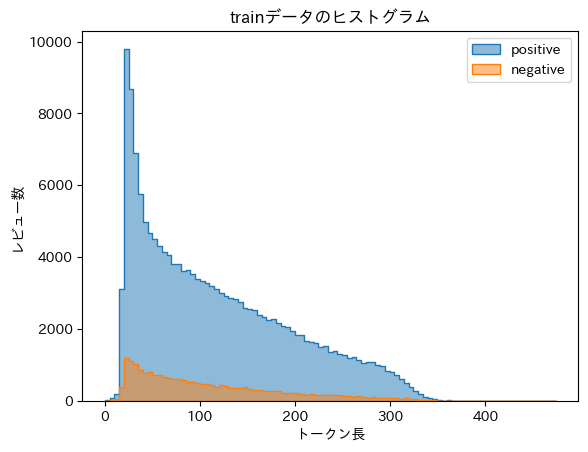

validationデータの平均トークン数: 114.55
validationデータの最大トークン数: 346
validationデータのポジティブ平均トークン数: 116.82
validationデータのネガティブ平均トークン数: 101.25


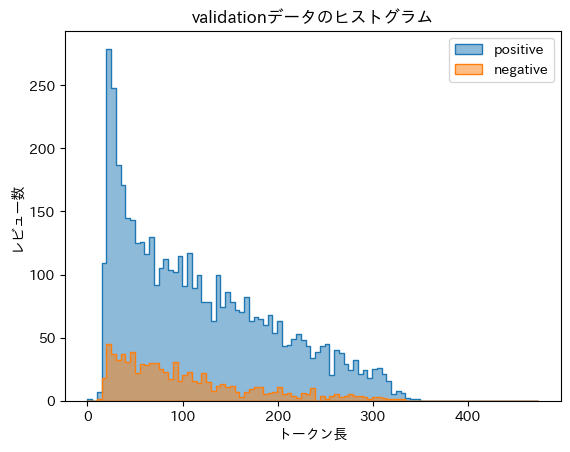

In [ ]:
def visualize_token_length(dataset: dict, target: str, bin_range: tuple):
    """
    データセットのトークン長分布を可視化する

    Args:
        dataset (dict): データセット.
        target (str): 可視化する対象 (train / validation)
        bin_range (tuple): ヒストグラムのビン数.
    """
    positive_token_lengths = [
        len(tokenizer.tokenize(example["sentence"])) for example in dataset if example["label"] == 0
    ]
    negative_token_lengths = [
        len(tokenizer.tokenize(example["sentence"])) for example in dataset if example["label"] == 1
    ]
    token_lengths = positive_token_lengths + negative_token_lengths
    print(f"{target}データの平均トークン数: {sum(token_lengths) / len(token_lengths):.2f}")
    print(f"{target}データの最大トークン数: {max(positive_token_lengths + negative_token_lengths)}")
    print(f"{target}データのポジティブ平均トークン数: {sum(positive_token_lengths) / len(positive_token_lengths):.2f}")
    print(f"{target}データのネガティブ平均トークン数: {sum(negative_token_lengths) / len(negative_token_lengths):.2f}")

    # ヒストグラムを描画
    sns.histplot(positive_token_lengths, binwidth=5, element="step", label="positive", alpha=0.5, binrange=bin_range)
    sns.histplot(negative_token_lengths, binwidth=5, element="step", label="negative", alpha=0.5, binrange=bin_range)
    plt.title(f"{target}データのヒストグラム")
    plt.xlabel("トークン長")
    plt.ylabel("レビュー数")
    plt.legend()
    plt.show()


# 最大トークン数を取得
max_token_train = max(
    [len(tokenizer.tokenize(example["sentence"])) for example in train_dataset]
)
max_token_valid = max(
    [len(tokenizer.tokenize(example["sentence"])) for example in valid_dataset]
)
bin_range = (0, max(max_token_train, max_token_valid) + 50)  # x軸のバッファで50足す

visualize_token_length(train_dataset, target="train", bin_range=bin_range)
visualize_token_length(valid_dataset, target="validation", bin_range=bin_range)

## ファインチューニングの実装

事前準備ができたので、モデルをファインチューニングします。

### (1) 評価関数の定義

以下の関数にて、学習時に利用する評価指標の計算を行います。

In [ ]:
def compute_metrics(eval_pred) -> dict:
    """
    評価指標を計算する

    Args:
        eval_pred: 評価結果のオブジェクト

    Returns:
        dict: 計算された評価指標の辞書
            - accuracy: 正解率
            - balanced_accuracy: バランス正解率
            - f1: F1-score
            - precision: 適合率
            - recall: 再現率
    """
    labels = eval_pred.label_ids
    predicts = eval_pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predicts, average="weighted")
    acc = accuracy_score(labels, predicts)
    balanced_acc = balanced_accuracy_score(labels, predicts)
    return {"accuracy": acc, "balanced_accuracy": balanced_acc, "f1": f1, "precision": precision, "recall": recall}


### (2) 学習条件の定義

学習の条件を設定するため、 `TrainingArguments` クラスに各種条件を指定します。

In [ ]:
training_args = TrainingArguments(
    output_dir=TRAIN_LOG_OUTPUT,  # モデルの保存先
    num_train_epochs=3,  # エポック数
    learning_rate=2e-5,  # 学習率
    per_device_train_batch_size=32,  # 学習時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    save_strategy="epoch",  # モデルの保存タイミング
    logging_strategy="epoch",  # ログの出力タイミング
    evaluation_strategy="epoch",  # 評価のタイミング
    optim="adafactor",  # 最適化手法
    gradient_accumulation_steps=4,  # 勾配蓄積のステップ数
    load_best_model_at_end=True,  # 最良のモデルを最後に読み込むかどうか
    metric_for_best_model="balanced_accuracy",  # 最良のモデルを判断する指標
    fp16=True,  # 16bit精度を利用するかどうか
    overwrite_output_dir=True,  # 出力先のディレクトリを上書きするかどうか
)

### (3) ファインチューニングの実行

`trainer.train()` 関数を実行してファインチューニングを開始します。
Google Colab で T4 の GPU を選択した場合には約3時間ほど時間がかかります。

In [ ]:
trainer = Trainer(
    model=model,  # 利用するモデル
    args=training_args,  # 学習時の設定
    train_dataset=tokenized_train_datasets,  # 訓練データ
    eval_dataset=tokenized_valid_datasets,  # 評価データ
    tokenizer=tokenizer,  # トークナイザ
    data_collator=data_collator,  # データの前処理
    compute_metrics=compute_metrics,  # 評価指標の計算
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall
0,0.125300,0.095479,0.966749,0.898265,0.965460,0.966658,0.966749
1,0.076200,0.127140,0.960382,0.871824,0.958149,0.960926,0.960382


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall
0,0.125300,0.095479,0.966749,0.898265,0.965460,0.966658,0.966749
1,0.076200,0.127140,0.960382,0.871824,0.958149,0.960926,0.960382
2,0.050000,0.137496,0.961797,0.880728,0.959949,0.961848,0.961797


TrainOutput(global_step=4395, training_loss=0.08380409909054146, metrics={'train_runtime': 9849.1095, 'train_samples_per_second': 57.12, 'train_steps_per_second': 0.446, 'total_flos': 8.617965906038227e+16, 'train_loss': 0.08380409909054146, 'epoch': 3.0})

In [ ]:
# 評価指標の確認
eval_metrics = trainer.evaluate(tokenized_valid_datasets)

eval_metrics

{'eval_loss': 0.09547875821590424,
 'eval_accuracy': 0.9667492041032897,
 'eval_balanced_accuracy': 0.8982646609787145,
 'eval_f1': 0.9654598262416575,
 'eval_precision': 0.9666576045428517,
 'eval_recall': 0.9667492041032897,
 'eval_runtime': 34.7797,
 'eval_samples_per_second': 162.566,
 'eval_steps_per_second': 5.089,
 'epoch': 3.0}

### (4) モデルの保存

次のコードを実行してファインチューニング済みのモデルを保存します。

In [ ]:
# モデルの保存
trainer.save_model(MODEL_OUTPUT)